Lesson 4 - Applied Regression Modeling - Transformations

In [1]:
import pandas as pd
import numpy as np
import os
import urllib.request
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

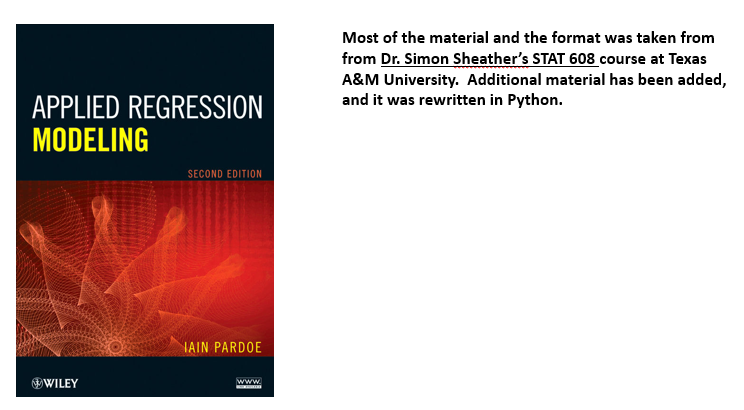

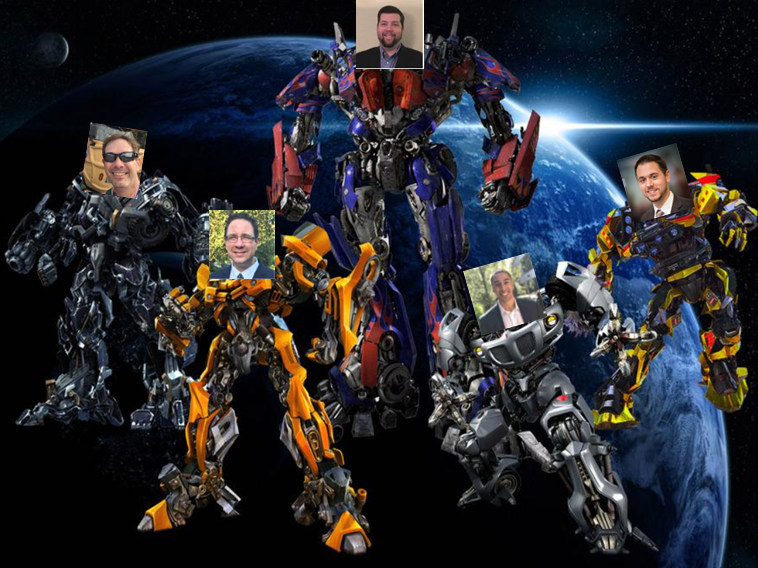

<b>ATTRIBUTION/ CITATION:</b> Most of this material including the course outline was taken from Dr. Simon Sheather's STAT 608 course at Texas A&M University. However, it uses additional examples and was adopted for use with Python. In addition, much of the course material used the textbook Applied Regression Modeling by Iain Pardoe. 

## Transformations can be used to:
- Overcome problems due to nonconstant variance
- Overcome problems due to nonlinearity
- Estimate percentage effects

# Example: Modeling Blu Ray Sales Revenue from DVD Sales Revenue
We wish to develop a regression model to predict Blu Ray Sales Revenue from DVD Sales Revenue. We shall focus on data from the 61 titles which appear in both the 2015 Top 100 selling DVD list and the 2015 Top 100 selling Blu Ray list.

SOURCES:
<p>
https://www.the-numbers.com/home-market/bluray-sales/2015
</p>
<p>
https://www.the-numbers.com/home-market/dvd-sales/2015
</p>

## Read In Data

In [39]:
def anderson_darling_test(data):
    
    from scipy.stats import anderson
    
    # normality test
    result = anderson(data)
    
    print('Statistic: %.3f' % result.statistic)
    
    p = 0
    
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [40]:
def shaprio_wilk_test(data):
    
    from scipy.stats import shapiro
    
    # normality test
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')  

In [41]:
def normal_test(data):
    
    from scipy.stats import normaltest

    # normality test
    stat, p = normaltest(data)

    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpret

    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [1]:
def read_table(url):
    import urllib.request

    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'

    headers={'User-Agent':user_agent,} 

    request=urllib.request.Request(url,None,headers) #The assembled request
    response = urllib.request.urlopen(request)
    
    return response.read()                           # The data u need
    

In [43]:
def get_video_disk_sales(save_to_pickle = True):

    bluray_link = 'https://www.the-numbers.com/home-market/bluray-sales/2015'
    dvd_link = 'https://www.the-numbers.com/home-market/dvd-sales/2015'

    bluray = pd.read_html(read_table(bluray_link))[0].rename(columns = {'Units Sold': 'Blu Ray Units Sold', 'Total Consumer Spending': 'Blu Ray Sales Revenue'})
    dvd = pd.read_html(read_table(dvd_link))[0].rename(columns = {'Units Sold': 'DVD Units Sold', 'Total Consumer Spending': 'DVD Sales Revenue'})
    interested_columns = ['Title','Blu Ray Units Sold','Blu Ray Sales Revenue','DVD Units Sold','DVD Sales Revenue']
    video_disk_sales = bluray.merge(dvd, how = 'inner', left_on = 'Title', right_on = 'Title')[interested_columns].sort_values(by = 'Title')
    
    # remove commas and dollar signs
    
    for col in ['Blu Ray Sales Revenue','DVD Sales Revenue']:
        video_disk_sales[col] = video_disk_sales[col].str.replace(',', '').str.replace('$', '').astype(int)
    
    if save_to_pickle:
        
        # Save as a pickle file
        video_disk_sales.to_pickle('./video_disk_sales.pkl')
        
    return video_disk_sales

In [44]:
if os.path.exists('./video_disk_sales.pkl'):
    video_disk_sales = pd.read_pickle('./video_disk_sales.pkl')
    print("Yay! It's there!")

else:
    video_disk_sales = get_video_disk_sales()
    
print('Length of the dataset is ', len(video_disk_sales))

display(video_disk_sales.head(5))
display(video_disk_sales.tail(5))

Yay! It's there!
Length of the dataset is  61


,Title,Blu Ray Units Sold,Blu Ray Sales Revenue,DVD Units Sold,DVD Sales Revenue
7,American Sniper,1735850,38907708,2556877,34785138
46,Annie,302279,6367964,708107,10477294
15,Ant-Man,1041107,22144021,856583,17123094
2,Big Hero 6,2686595,52161672,2553831,41878065
13,Cinderella,1112322,23541758,925118,14612596


,Title,Blu Ray Units Sold,Blu Ray Sales Revenue,DVD Units Sold,DVD Sales Revenue
57,The Maze Runner,222649,4297098,689933,10021306
34,The SpongeBob Movie: Sponge Out of Water,431465,10263799,819393,12166598
43,Tinker Bell and the Legend of The Neverbeast,340887,7440656,540625,10047271
39,Unbroken,394249,7863359,710509,9746161
56,War Room,228970,4577113,802344,15035927


# Regression Plot and Residuals Blue Ray Sales Revenue

## Model Code

In [45]:
import statsmodels.api as sm                      #import statsmodels

df = video_disk_sales.copy()                      # get data

y = df['y'] = df['Blu Ray Sales Revenue']         # target variable
x = df['DVD Sales Revenue']                       # predictor variable
x = sm.add_constant(x)                            # add constant

ols_model = sm.OLS(y, x)                          # delcare model architecture
fitted = ols_model.fit()                          # fit model                                        
yhat = df['y_hat'] = fitted.predict(x)            # makes predictions 

influence = fitted.get_influence()                # get diagnostic data
df['residuals'] = y - yhat                        # residuals
df['studentized_residuals'] = influence.resid_studentized_external  # studentized residuals
df['cooks_distance'] = influence.cooks_distance[0]        # cook's distance

summary = fitted.summary()                        # summary of the model 
non_transformed_model_data = df.copy()               # copy the results later for analysis
df.head(5)

,Title,Blu Ray Units Sold,Blu Ray Sales Revenue,DVD Units Sold,DVD Sales Revenue,y,y_hat,residuals,studentized_residuals,cooks_distance
7,American Sniper,1735850,38907708,2556877,34785138,38907708,4.228456e+07,-3.376851e+06,-0.421975,0.008571
46,Annie,302279,6367964,708107,10477294,6367964,8.867889e+06,-2.499925e+06,-0.301629,0.001030
15,Ant-Man,1041107,22144021,856583,17123094,22144021,1.800406e+07,4.139965e+06,0.498898,0.002148
2,Big Hero 6,2686595,52161672,2553831,41878065,52161672,5.203540e+07,1.262686e+05,0.016320,0.000024
13,Cinderella,1112322,23541758,925118,14612596,23541758,1.455280e+07,8.988954e+06,1.091917,0.010061


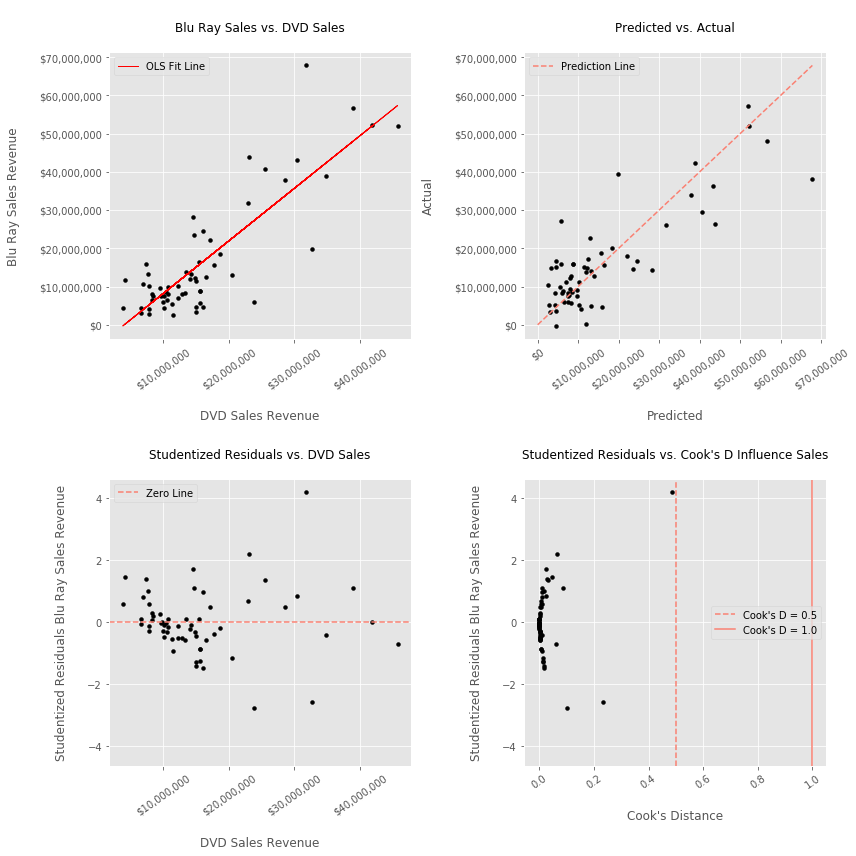

                              OLS Regression Results                             
Dep. Variable:     Blu Ray Sales Revenue   R-squared:                       0.705
Model:                               OLS   Adj. R-squared:                  0.700
Method:                    Least Squares   F-statistic:                     140.7
Date:                   Fri, 25 Sep 2020   Prob (F-statistic):           2.93e-17
Time:                           13:12:45   Log-Likelihood:                -1057.5
No. Observations:                     61   AIC:                             2119.
Df Residuals:                         59   BIC:                             2123.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const   

In [46]:
with plt.style.context('ggplot'):
    
    fig = plt.figure(figsize = (12,12))
    ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
    ax3 = plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=1)
    ax4 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, colspan=1)

    fmt = '${x:,.0f}'
    tick = ticker.StrMethodFormatter(fmt)
    residuals_limit = max(min(df['studentized_residuals']), max(df['studentized_residuals']))

    ax1.set_title('\nBlu Ray Sales vs. DVD Sales\n', fontsize = 12)
    ax1.scatter(df['DVD Sales Revenue'], df['Blu Ray Sales Revenue'], s = 15, color = 'black')
    ax1.plot(df['DVD Sales Revenue'],df['y_hat'], color = 'r', linewidth = 1, label = 'OLS Fit Line')
    ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.yaxis.set_major_formatter(tick) 
    ax1.xaxis.set_major_formatter(tick) 
    ax1.set_xlabel('\nDVD Sales Revenue')
    ax1.set_ylabel('Blu Ray Sales Revenue\n')
    ax1.tick_params(axis='x', rotation=35)
    ax1.legend(loc = 2)

    max_limits = max(max(df['y']),max(df['y_hat']))
    prediction_line = [0, max_limits]
    ax2.set_title('\nPredicted vs. Actual\n', fontsize = 12)
    ax2.scatter(df['y'], df['y_hat'], s = 15, color = 'black')
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.plot(prediction_line,prediction_line, color = 'salmon', linestyle = '--', label = 'Prediction Line')
    ax2.yaxis.set_major_formatter(tick) 
    ax2.xaxis.set_major_formatter(tick) 
    ax2.set_xlabel('\nPredicted')
    ax2.set_ylabel('Actual\n')
    ax2.tick_params(axis='x', rotation=35)
    ax2.legend(loc = 2)

    ax3.set_title('\nStudentized Residuals vs. DVD Sales\n', fontsize = 12)
    ax3.scatter(df['DVD Sales Revenue'], df['studentized_residuals'], s = 15, color = 'black')
    ax3.axhline(y=0, color = 'salmon', linestyle = '--', label = 'Zero Line')
    ax3.xaxis.set_major_formatter(tick) 
    ax3.set_xlabel('\nDVD Sales Revenue')
    ax3.set_ylabel('\nStudentized Residuals Blu Ray Sales Revenue\n')
    ax3.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
    ax3.tick_params(axis='x', rotation=35)
    ax3.legend(loc = 2)

    ax4.set_title("\nStudentized Residuals vs. Cook's D Influence Sales\n", fontsize = 12)
    ax4.scatter(df['cooks_distance'], df['studentized_residuals'], s = 15, color = 'black')
    ax4.axvline(x=0.5, color = 'salmon', linestyle = '--', label = "Cook's D = 0.5")
    ax4.axvline(x=1.0, color = 'salmon', linestyle = '-', label = "Cook's D = 1.0")
    ax4.set_xlabel("\nCook's Distance")
    ax4.set_ylabel('\nStudentized Residuals Blu Ray Sales Revenue\n')
    ax4.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
    ax4.tick_params(axis='x', rotation=35)
    ax4.legend(loc = 5)

    plt.tight_layout()
    plt.show()

    print(summary)

# Conclusions

- The variability of the studentized residuals increases along with X (DVD Sales Revenue). Thus, <b>there is evidence that the assumption of constant error variance is violated.</b>
- What should we do next? 

# Overcoming non-constant error variance
- When non constant variance exists, it is often possible to <b>transform</b> one or both of the regression variables to produce a model in which the error variance is constant
- Alternatively, we can use <b>weighted least squares</b> to account for the changing variance (with weights equal to 1/variance). We shall consider this approach in the next topic.
- We begin by considering transformations

# Transformations
- A transformation is a mathematical function applied to a variable in our dataset. 
- Commonly used transformations are:
    - Square Root
    - Logarithmic, Log e
    - Reciprocal 1/.
- Transformations can be applied to Y or X or both

# Logarithmic Transformations, Log e
<span class="tex2jax_ignore">
<p><p>
- Logarithmic transformations are typically used for highly skewed data that goes across a number of orders of magnitude. For example, Blu Ray sales revenue ranges from just over $1 million to just over $80 million (i.e., it goes from $1M to $10M and from $10M to $100M)</p>
<p>
    - We shall see that <b>logarithmic transformations</b> (to the base e) enable us to readily <b>estimate percentage effects</b>    
</p>
<p>
    - Throughout this course, whenever we use the term <b>"log"</b> we mean <b>"log e" (i.e. log to the base e)</b>
    </p>

## Review of Logarithms

https://www.youtube.com/watch?v=up21mvokyQ4&t=233s

- ln(5) = 1.6094379124341003
- e^ln(5) = 5

In [47]:
print(np.log(5))
print(np.exp(np.log(5)))

1.6094379124341003
4.999999999999999


In [48]:
np.log(1)

0.0

In [49]:
np.log(0)

C:\Users\ahorvitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

In [52]:
np.log(0+1)

0.0

In [53]:
np.log1p(0)

0.0

In [57]:
np.exp(0)-1

0.0

### Plot histograms of the initial data

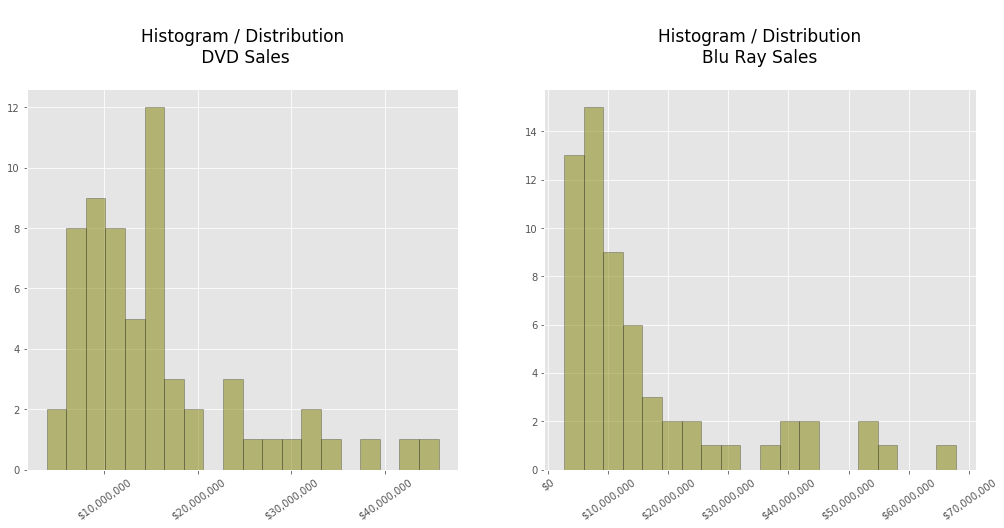

In [58]:
with plt.style.context('ggplot'):
    
    fig = plt.figure(figsize = (17,7))
    ax1 = plt.subplot2grid((1, 2), (0, 0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((1, 2), (0, 1), rowspan=1, colspan=1)

    fmt = '${x:,.0f}'
    tick = ticker.StrMethodFormatter(fmt)

    ax1.set_title('\nHistogram / Distribution\n DVD Sales\n', fontsize = 17)
    ax1.hist(video_disk_sales['DVD Sales Revenue'], color = 'olive', alpha = 0.5, edgecolor='black', bins = 20)
    ax1.xaxis.set_major_formatter(tick) 
    ax1.tick_params(axis='x', rotation=35)

    ax2.set_title('\nHistogram / Distribution\nBlu Ray Sales\n', fontsize = 17)
    ax2.hist(video_disk_sales['Blu Ray Sales Revenue'], color = 'olive', alpha = 0.5, edgecolor='black', bins = 20)
    ax2.xaxis.set_major_formatter(tick) 
    ax2.tick_params(axis='x', rotation=35)

    plt.show()

### Log transform the data and replot it...

In [59]:
video_disk_sales['Log[Blu Ray Sales Revenue]'] = np.log1p(video_disk_sales['Blu Ray Sales Revenue'])
video_disk_sales['Log[DVD Sales Revenue]'] = np.log1p(video_disk_sales['DVD Sales Revenue'])

video_disk_sales.head()

,Title,Blu Ray Units Sold,Blu Ray Sales Revenue,DVD Units Sold,DVD Sales Revenue,Log[Blu Ray Sales Revenue],Log[DVD Sales Revenue]
7,American Sniper,1735850,38907708,2556877,34785138,17.476703,17.364701
46,Annie,302279,6367964,708107,10477294,15.666791,16.164721
15,Ant-Man,1041107,22144021,856583,17123094,16.913078,16.655939
2,Big Hero 6,2686595,52161672,2553831,41878065,17.769859,17.550273
13,Cinderella,1112322,23541758,925118,14612596,16.974286,16.497395


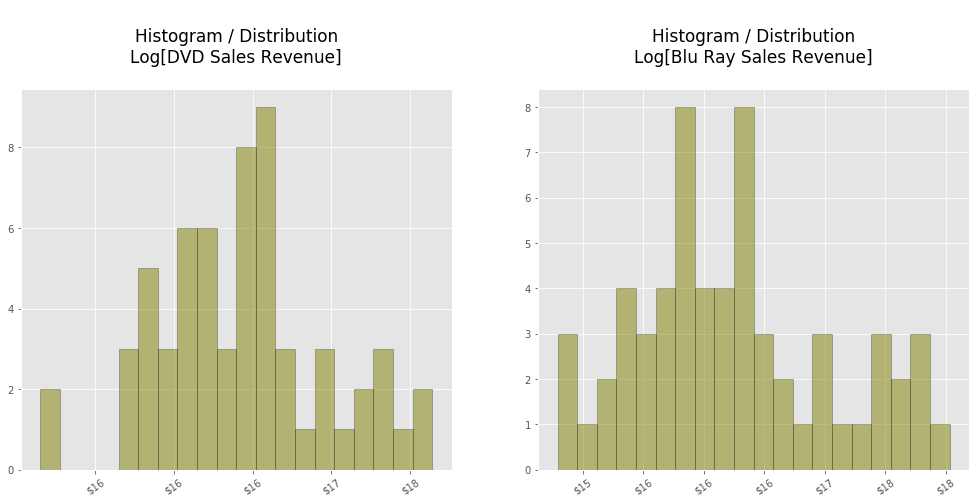

In [61]:
with plt.style.context('ggplot'):
    
    fig = plt.figure(figsize = (17,7))
    ax1 = plt.subplot2grid((1, 2), (0, 0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((1, 2), (0, 1), rowspan=1, colspan=1)

    fmt = '${x:,.0f}'
    tick = ticker.StrMethodFormatter(fmt)

    ax1.set_title('\nHistogram / Distribution\nLog[DVD Sales Revenue]\n', fontsize = 17)
    ax1.hist(video_disk_sales['Log[DVD Sales Revenue]'], color = 'olive', alpha = 0.5, edgecolor='black', bins = 20)
    ax1.xaxis.set_major_formatter(tick) 
    ax1.tick_params(axis='x', rotation=35)

    ax2.set_title('\nHistogram / Distribution\nLog[Blu Ray Sales Revenue]\n', fontsize = 17)
    ax2.hist(video_disk_sales['Log[Blu Ray Sales Revenue]'], color = 'olive', alpha = 0.5, edgecolor='black', bins = 20)
    ax2.xaxis.set_major_formatter(tick) 
    ax2.tick_params(axis='x', rotation=35)

    plt.show()

#  Additional Tests for Normality (this does necessarily fix non-constant variance, so it's not required, but it's a good idea to check the normality assumption before modeling so you know how your data is shaped...)

EXAMPLE:  A financial analyst boasts, "I have never seen a non-normal distribution before. I don't know when you would use that in a business setting."

## Shapiro Wilk Test

<p>The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution, named for Samuel Shapiro and Martin Wilk. In practice, the Shapiro-Wilk test is believed to be a reliable test of normality, although there is some suggestion that the test may be suitable for smaller samples of data, e.g. thousands of observations or fewer. <b>(SOURCE: Jason Brownlee)</b></p>

https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

### DVD Sales Revenue Shapiro Wilk Test

In [62]:
# Test on NON-Log transformed data
shaprio_wilk_test(video_disk_sales['DVD Sales Revenue'])

Statistics=0.848, p=0.000
Sample does not look Gaussian (reject H0)


In [63]:
# Log[DVD Sales Revenue]
shaprio_wilk_test(video_disk_sales['Log[DVD Sales Revenue]'])

Statistics=0.979, p=0.370
Sample looks Gaussian (fail to reject H0)


### Blu Ray Sales Revenue Shapiro Wilk Test

In [64]:
# Test on NON-Log transformed data
shaprio_wilk_test(video_disk_sales['Blu Ray Sales Revenue'])

Statistics=0.762, p=0.000
Sample does not look Gaussian (reject H0)


In [65]:
# Log[Blu Ray Sales Revenu]
shaprio_wilk_test(video_disk_sales['Log[Blu Ray Sales Revenue]'])

Statistics=0.964, p=0.069
Sample looks Gaussian (fail to reject H0)


## D’Agostino’s $K^{2}$ Test (Normal Test in Scipy)

The <b>D’Agostino’s $K^{2}$</b> test calculates summary statistics from the data, namely kurtosis and skewness, to determine if the data distribution departs from the normal distribution, named for Ralph D’Agostino. <b>Skew</b> is a quantification of how much a distribution is pushed left or right, a measure of asymmetry in the distribution. <b>Kurtosis</b> quantifies how much of the distribution is in the tail. It is a simple and commonly used statistical test for normality. The <b>D’Agostino’s $K^{2}$</b> test is available via the <b>normaltest()</b> SciPy function and returns the test statistic and the p-value.

<b>(SOURCE: Jason Brownlee)</b></p>

https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/


### DVD Sales Revenue - D’Agostino’s $K^{2}$ Test

In [66]:
# Test on NON-Log transformed data
normal_test(video_disk_sales['DVD Sales Revenue'])

Statistics=21.766, p=0.000
Sample does not look Gaussian (reject H0)


In [67]:
# Log[DVD Sales Revenue]
normal_test(video_disk_sales['Log[DVD Sales Revenue]'])

Statistics=0.512, p=0.774
Sample looks Gaussian (fail to reject H0)


### Blu Ray Sales Revenue - D’Agostino’s $K^{2}$ Test

In [76]:
# Test on NON-Log transformed data
normal_test(video_disk_sales['Blu Ray Sales Revenue'])

Statistics=26.272, p=0.000
Sample does not look Gaussian (reject H0)


In [77]:
# Log[Blu Ray Sales Revenu]
normal_test(video_disk_sales['Log[Blu Ray Sales Revenue]'])

Statistics=2.826, p=0.243
Sample looks Gaussian (fail to reject H0)


## Anderson-Darling Test

<b>Anderson-Darling Test</b> is a statistical test that can be used to evaluate whether a data sample comes from one of among many known data samples, named for Theodore Anderson and Donald Darling.

It can be used to check whether a data sample is normal. The test is a modified version of a more sophisticated nonparametric goodness-of-fit statistical test called the <b>Kolmogorov-Smirnov test</b>.

A feature of the Anderson-Darling test is that it returns a list of critical values rather than a single p-value. This can provide the basis for a more thorough interpretation of the result.

The <b>anderson() SciPy function</b> implements the Anderson-Darling test. It takes as parameters the data sample and the name of the distribution to test it against. By default, the test will check against the Gaussian distribution (dist=’norm’).

<b>(SOURCE: Jason Brownlee)</b></p>

https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

### DVD Sales Revenue - Anderson Darling Test

In [74]:
# Test on NON-Log transformed data
anderson_darling_test(video_disk_sales['DVD Sales Revenue'])

Statistic: 3.166
15.000: 0.544, data does not look normal (reject H0)
10.000: 0.620, data does not look normal (reject H0)
5.000: 0.743, data does not look normal (reject H0)
2.500: 0.867, data does not look normal (reject H0)
1.000: 1.031, data does not look normal (reject H0)


In [78]:
# Log[DVD Sales Revenue]
anderson_darling_test(video_disk_sales['Log[DVD Sales Revenue]'])

Statistic: 0.488
15.000: 0.544, data looks normal (fail to reject H0)
10.000: 0.620, data looks normal (fail to reject H0)
5.000: 0.743, data looks normal (fail to reject H0)
2.500: 0.867, data looks normal (fail to reject H0)
1.000: 1.031, data looks normal (fail to reject H0)


### Blu Ray Sales Revenue - Anderson Darling Test

In [79]:
# Test on NON-Log transformed data
anderson_darling_test(video_disk_sales['Blu Ray Sales Revenue'])

Statistic: 5.512
15.000: 0.544, data does not look normal (reject H0)
10.000: 0.620, data does not look normal (reject H0)
5.000: 0.743, data does not look normal (reject H0)
2.500: 0.867, data does not look normal (reject H0)
1.000: 1.031, data does not look normal (reject H0)


In [80]:
# Log[Blu Ray Sales Revenu]
anderson_darling_test(video_disk_sales['Log[Blu Ray Sales Revenue]'])

Statistic: 0.706
15.000: 0.544, data does not look normal (reject H0)
10.000: 0.620, data does not look normal (reject H0)
5.000: 0.743, data looks normal (fail to reject H0)
2.500: 0.867, data looks normal (fail to reject H0)
1.000: 1.031, data looks normal (fail to reject H0)


# Final Visual Compare Log Transformation side by side

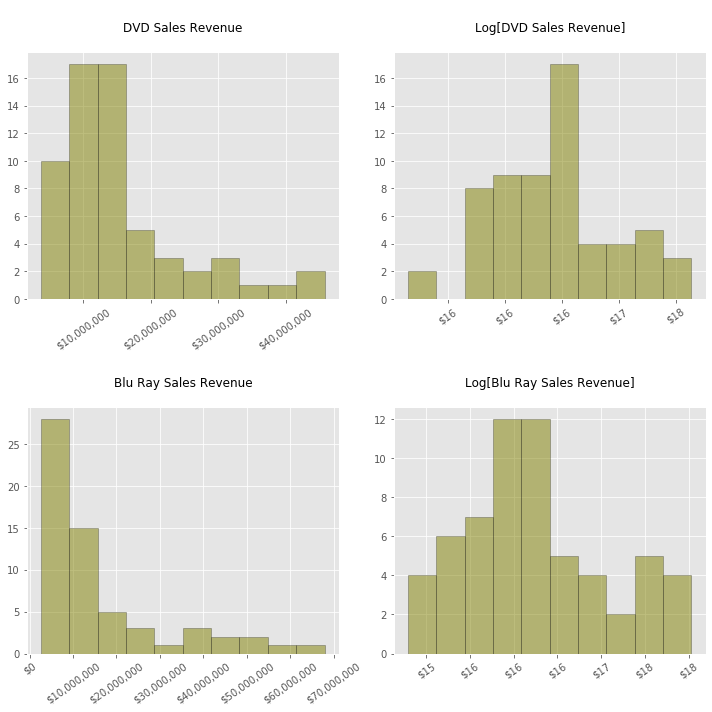

In [84]:
with plt.style.context('ggplot'):
    
    fig = plt.figure(figsize = (10,10))

    ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
    ax3 = plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=1)
    ax4 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, colspan=1)

    fmt = '${x:,.0f}'
    tick = ticker.StrMethodFormatter(fmt)

    ax1.set_title('\nDVD Sales Revenue\n', fontsize = 12)
    ax1.hist(video_disk_sales['DVD Sales Revenue'], color = 'olive', alpha = 0.5, edgecolor='black', bins = 10)
    ax1.xaxis.set_major_formatter(tick) 
    ax1.tick_params(axis='x', rotation=35)

    ax2.set_title('\nLog[DVD Sales Revenue]\n', fontsize = 12)
    ax2.hist(video_disk_sales['Log[DVD Sales Revenue]'], color = 'olive', alpha = 0.5, edgecolor='black', bins = 10)
    ax2.xaxis.set_major_formatter(tick) 
    ax2.tick_params(axis='x', rotation=35)

    ax3.set_title('\nBlu Ray Sales Revenue\n', fontsize = 12)
    ax3.hist(video_disk_sales['Blu Ray Sales Revenue'], color = 'olive', alpha = 0.5, edgecolor='black', bins = 10)
    ax3.xaxis.set_major_formatter(tick) 
    ax3.tick_params(axis='x', rotation=35)

    ax4.set_title('\nLog[Blu Ray Sales Revenue]\n', fontsize = 12)
    ax4.hist(video_disk_sales['Log[Blu Ray Sales Revenue]'], color = 'olive', alpha = 0.5, edgecolor='black', bins = 10)
    ax4.xaxis.set_major_formatter(tick) 
    ax4.tick_params(axis='x', rotation=35)
    plt.tight_layout()
    plt.show()

# Fit the log transformed Data

In [82]:
import statsmodels.api as sm                     #import statsmodels

df = video_disk_sales.copy()                     # get data

y = df['y'] = df['Log[Blu Ray Sales Revenue]']   # target variable
x = df['Log[DVD Sales Revenue]']                 # predictor variable
x = sm.add_constant(x)                           # add constant

ols_model = sm.OLS(y, x)                         # delcare model architecture
fitted = ols_model.fit()                         # fit model                                        
yhat = df['y_hat'] = fitted.predict(x)           # makes predictions 

influence = fitted.get_influence()               # get diagnostic data
df['residuals'] = y - yhat                       # residuals
df['studentized_residuals'] = influence.resid_studentized_external  # studentized residuals
df['cooks_distance'] = influence.cooks_distance[0]        # cook's distance

summary = fitted.summary()                       # summary of the model 
transformed_model_data = df.copy()               # copy the model results
df.head(5)

,Title,Blu Ray Units Sold,Blu Ray Sales Revenue,DVD Units Sold,DVD Sales Revenue,Log[Blu Ray Sales Revenue],Log[DVD Sales Revenue],y,y_hat,residuals,studentized_residuals,cooks_distance
7,American Sniper,1735850,38907708,2556877,34785138,17.476703,17.364701,17.476703,17.263915,0.212788,0.379456,0.005273
46,Annie,302279,6367964,708107,10477294,15.666791,16.164721,15.666791,15.964049,-0.297259,-0.517790,0.002828
15,Ant-Man,1041107,22144021,856583,17123094,16.913078,16.655939,16.913078,16.496156,0.416923,0.727488,0.005281
2,Big Hero 6,2686595,52161672,2553831,41878065,17.769859,17.550273,17.769859,17.464934,0.304925,0.551096,0.015105
13,Cinderella,1112322,23541758,925118,14612596,16.974286,16.497395,16.974286,16.324414,0.649872,1.139805,0.010960


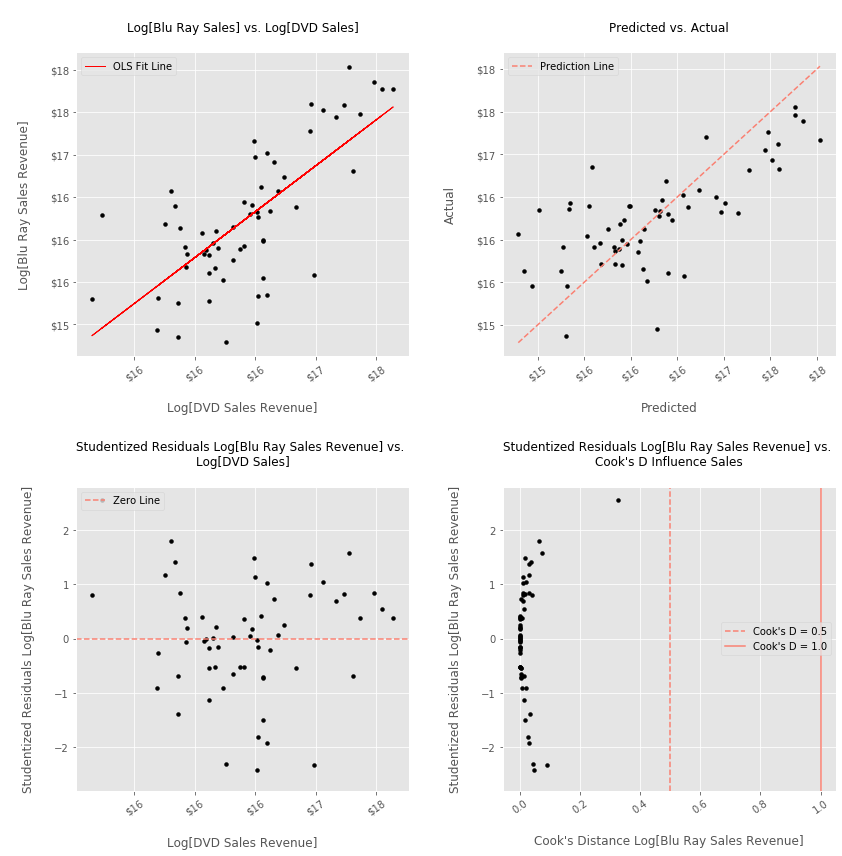

                                OLS Regression Results                                
Dep. Variable:     Log[Blu Ray Sales Revenue]   R-squared:                       0.508
Model:                                    OLS   Adj. R-squared:                  0.499
Method:                         Least Squares   F-statistic:                     60.87
Date:                        Fri, 25 Sep 2020   Prob (F-statistic):           1.18e-10
Time:                                13:47:20   Log-Likelihood:                -51.934
No. Observations:                          61   AIC:                             107.9
Df Residuals:                              59   BIC:                             112.1
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [85]:
with plt.style.context('ggplot'):
    
    fig = plt.figure(figsize = (12,12))
    ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
    ax3 = plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=1)
    ax4 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, colspan=1)

    fmt = '${x:,.0f}'
    tick = ticker.StrMethodFormatter(fmt)
    residuals_limit = max(min(df['studentized_residuals']), max(df['studentized_residuals']))

    ax1.set_title('\nLog[Blu Ray Sales] vs. Log[DVD Sales]\n', fontsize = 12)
    ax1.scatter(df['Log[DVD Sales Revenue]'], df['Log[Blu Ray Sales Revenue]'], s = 15, color = 'black')
    ax1.plot(df['Log[DVD Sales Revenue]'],df['y_hat'], color = 'r', linewidth = 1, label = 'OLS Fit Line')
    ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.yaxis.set_major_formatter(tick) 
    ax1.xaxis.set_major_formatter(tick) 
    ax1.set_xlabel('\nLog[DVD Sales Revenue]')
    ax1.set_ylabel('Log[Blu Ray Sales Revenue]\n')
    ax1.tick_params(axis='x', rotation=35)
    ax1.legend(loc = 2)

    max_limits = max(max(df['y']),max(df['y_hat']))
    min_limits = min(min(df['y']),min(df['y_hat']))

    prediction_line = [min_limits, max_limits]
    ax2.set_title('\nPredicted vs. Actual\n', fontsize = 12)
    ax2.scatter(df['y'], df['y_hat'], s = 15, color = 'black')
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.plot(prediction_line,prediction_line, color = 'salmon', linestyle = '--', label = 'Prediction Line')
    ax2.yaxis.set_major_formatter(tick) 
    ax2.xaxis.set_major_formatter(tick) 
    ax2.set_xlabel('\nPredicted')
    ax2.set_ylabel('Actual\n')
    ax2.tick_params(axis='x', rotation=35)
    ax2.legend(loc = 2)

    ax3.set_title('\nStudentized Residuals Log[Blu Ray Sales Revenue] vs. \nLog[DVD Sales]\n', fontsize = 12)
    ax3.scatter(df['Log[DVD Sales Revenue]'], df['studentized_residuals'], s = 15, color = 'black')
    ax3.axhline(y=0, color = 'salmon', linestyle = '--', label = 'Zero Line')
    ax3.xaxis.set_major_formatter(tick) 
    ax3.set_xlabel('\nLog[DVD Sales Revenue]')
    ax3.set_ylabel('\nStudentized Residuals Log[Blu Ray Sales Revenue]\n')
    ax3.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
    ax3.tick_params(axis='x', rotation=35)
    ax3.legend(loc = 2)

    ax4.set_title("\nStudentized Residuals Log[Blu Ray Sales Revenue] vs. \nCook's D Influence Sales\n", fontsize = 12)
    ax4.scatter(df['cooks_distance'], df['studentized_residuals'], s = 15, color = 'black')
    ax4.axvline(x=0.5, color = 'salmon', linestyle = '--', label = "Cook's D = 0.5")
    ax4.axvline(x=1.0, color = 'salmon', linestyle = '-', label = "Cook's D = 1.0")
    ax4.set_xlabel("\nCook's Distance Log[Blu Ray Sales Revenue]")
    ax4.set_ylabel('\nStudentized Residuals Log[Blu Ray Sales Revenue]\n')
    ax4.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
    ax4.tick_params(axis='x', rotation=35)
    ax4.legend(loc = 5)

    plt.tight_layout()
    plt.show()

    print(summary)

Suppose that both X and Y are log transformed. For example, our least squares equation for the DVD sales example is as
follows:

- $log(\hat{y\\}) = {b_0\\}+{b_1\\}log(x)$
- Log[Blu Ray Sales Revenue] = <b>-1.5462</b>+<b>1.0832</b>*Log[DVD Sales Revenue]

# Compare Side By Side

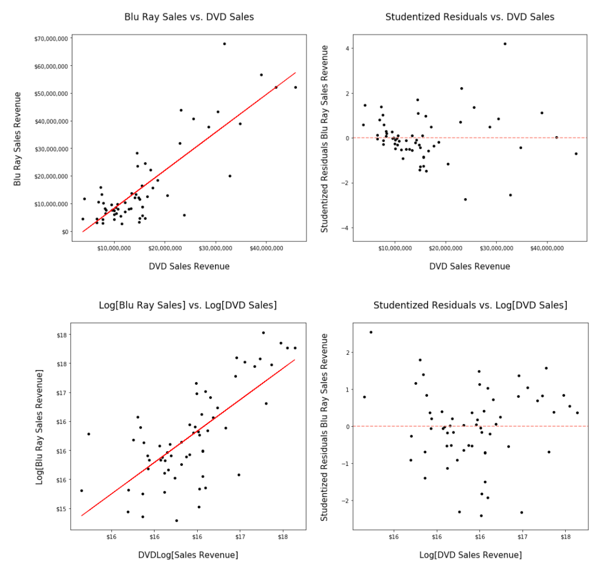

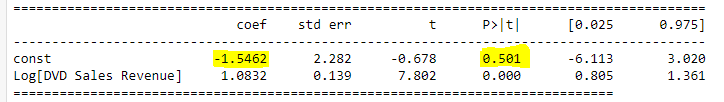

## We fixed the problem with non-constant variance; however, the constant (y-intercept) is not significant, so we'll remove it and redo the regression. 

In [86]:
import statsmodels.api as sm                     #import statsmodels

df = video_disk_sales.copy()                     # get data

y = df['y'] = df['Log[Blu Ray Sales Revenue]']   # target variable
x = df['Log[DVD Sales Revenue]']                 # predictor variable
#x = sm.add_constant(x)                           # add constant

ols_model = sm.OLS(y, x)                         # delcare model architecture
fitted = ols_model.fit()                         # fit model                                        
yhat = df['y_hat'] = fitted.predict(x)           # makes predictions 

influence = fitted.get_influence()               # get diagnostic data
df['residuals'] = y - yhat                       # residuals
df['studentized_residuals'] = influence.resid_studentized_external  # studentized residuals
df['cooks_distance'] = influence.cooks_distance[0]        # cook's distance

summary = fitted.summary()                       # summary of the model 
transformed_model_data = df.copy()               # copy the model results
df.head(5)

,Title,Blu Ray Units Sold,Blu Ray Sales Revenue,DVD Units Sold,DVD Sales Revenue,Log[Blu Ray Sales Revenue],Log[DVD Sales Revenue],y,y_hat,residuals,studentized_residuals,cooks_distance
7,American Sniper,1735850,38907708,2556877,34785138,17.476703,17.364701,17.476703,17.177436,0.299267,0.523171,0.005164
46,Annie,302279,6367964,708107,10477294,15.666791,16.164721,15.666791,15.990397,-0.323607,-0.565237,0.005207
15,Ant-Man,1041107,22144021,856583,17123094,16.913078,16.655939,16.913078,16.476317,0.436761,0.764968,0.010090
2,Big Hero 6,2686595,52161672,2553831,41878065,17.769859,17.550273,17.769859,17.361007,0.408852,0.716330,0.009853
13,Cinderella,1112322,23541758,925118,14612596,16.974286,16.497395,16.974286,16.319483,0.654803,1.153832,0.022234


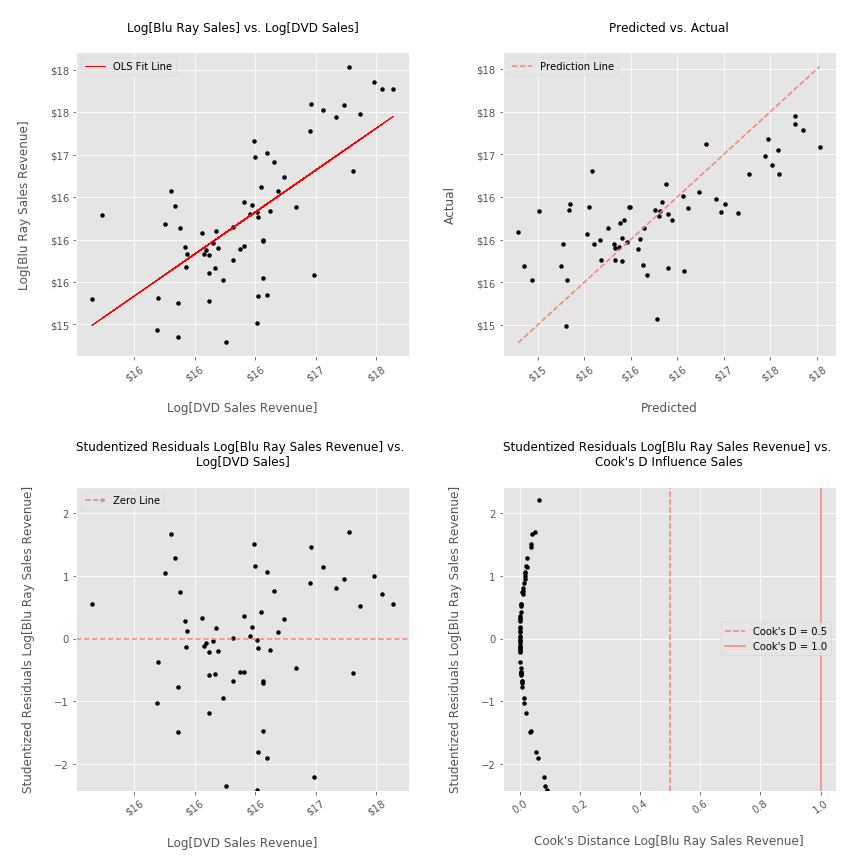

                                     OLS Regression Results                                    
Dep. Variable:     Log[Blu Ray Sales Revenue]   R-squared (uncentered):                   0.999
Model:                                    OLS   Adj. R-squared (uncentered):              0.999
Method:                         Least Squares   F-statistic:                          4.897e+04
Date:                        Fri, 25 Sep 2020   Prob (F-statistic):                    4.38e-89
Time:                                14:05:37   Log-Likelihood:                         -52.170
No. Observations:                          61   AIC:                                      106.3
Df Residuals:                              60   BIC:                                      108.5
Df Model:                                   1                                                  
Covariance Type:                    nonrobust                                                  
                             coef    std

In [87]:
with plt.style.context('ggplot'):
    
    fig = plt.figure(figsize = (12,12))
    ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
    ax3 = plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=1)
    ax4 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, colspan=1)

    fmt = '${x:,.0f}'
    tick = ticker.StrMethodFormatter(fmt)
    residuals_limit = max(min(df['studentized_residuals']), max(df['studentized_residuals']))

    ax1.set_title('\nLog[Blu Ray Sales] vs. Log[DVD Sales]\n', fontsize = 12)
    ax1.scatter(df['Log[DVD Sales Revenue]'], df['Log[Blu Ray Sales Revenue]'], s = 15, color = 'black')
    ax1.plot(df['Log[DVD Sales Revenue]'],df['y_hat'], color = 'r', linewidth = 1, label = 'OLS Fit Line')
    ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.yaxis.set_major_formatter(tick) 
    ax1.xaxis.set_major_formatter(tick) 
    ax1.set_xlabel('\nLog[DVD Sales Revenue]')
    ax1.set_ylabel('Log[Blu Ray Sales Revenue]\n')
    ax1.tick_params(axis='x', rotation=35)
    ax1.legend(loc = 2)

    max_limits = max(max(df['y']),max(df['y_hat']))
    min_limits = min(min(df['y']),min(df['y_hat']))

    prediction_line = [min_limits, max_limits]
    ax2.set_title('\nPredicted vs. Actual\n', fontsize = 12)
    ax2.scatter(df['y'], df['y_hat'], s = 15, color = 'black')
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.plot(prediction_line,prediction_line, color = 'salmon', linestyle = '--', label = 'Prediction Line')
    ax2.yaxis.set_major_formatter(tick) 
    ax2.xaxis.set_major_formatter(tick) 
    ax2.set_xlabel('\nPredicted')
    ax2.set_ylabel('Actual\n')
    ax2.tick_params(axis='x', rotation=35)
    ax2.legend(loc = 2)

    ax3.set_title('\nStudentized Residuals Log[Blu Ray Sales Revenue] vs. \nLog[DVD Sales]\n', fontsize = 12)
    ax3.scatter(df['Log[DVD Sales Revenue]'], df['studentized_residuals'], s = 15, color = 'black')
    ax3.axhline(y=0, color = 'salmon', linestyle = '--', label = 'Zero Line')
    ax3.xaxis.set_major_formatter(tick) 
    ax3.set_xlabel('\nLog[DVD Sales Revenue]')
    ax3.set_ylabel('\nStudentized Residuals Log[Blu Ray Sales Revenue]\n')
    ax3.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
    ax3.tick_params(axis='x', rotation=35)
    ax3.legend(loc = 2)

    ax4.set_title("\nStudentized Residuals Log[Blu Ray Sales Revenue] vs. \nCook's D Influence Sales\n", fontsize = 12)
    ax4.scatter(df['cooks_distance'], df['studentized_residuals'], s = 15, color = 'black')
    ax4.axvline(x=0.5, color = 'salmon', linestyle = '--', label = "Cook's D = 0.5")
    ax4.axvline(x=1.0, color = 'salmon', linestyle = '-', label = "Cook's D = 1.0")
    ax4.set_xlabel("\nCook's Distance Log[Blu Ray Sales Revenue]")
    ax4.set_ylabel('\nStudentized Residuals Log[Blu Ray Sales Revenue]\n')
    ax4.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
    ax4.tick_params(axis='x', rotation=35)
    ax4.legend(loc = 5)

    plt.tight_layout()
    plt.show()

    print(summary)

# How do we interpret models based on logarithms? 

## both X and y log transformed?

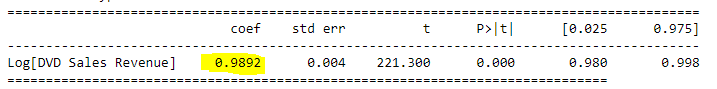

Suppose that both X and Y are log transformed. For example, our least squares equation for the DVD sales example is as
follows:

- $log(\hat{y\\}) = {b_0\\}+{b_1\\}log(x)$
- Log[Blu Ray Sales Revenue] = <b>0.9892</b>*Log[DVD Sales Revenue]

For this model, $\hat{b_1\\}$ = <b>0.9892</b> 

<b>Percentage Change Calculation:</b> $(1.01^{\hat{b_1\\}}-1) x 100$ = %Change

In [35]:
((1.01**0.9892)-1)*100

0.9891467622796579

$= (1.01^{0.9892}-1)$ x 100 = <b>0.9891% $\sim 1$%</b> 

<b>CONCLUSION: Therefore we can conclude that a 1% increase in DVD Sales Revenue is predicted to produce a 0.9891% $\sim 1$% change in Blue Ray Sales Revenue.</b>

## Just Y log transformed, NOT X

Suppose that just Y is log transformed. Thus, our model is of the form:
- $log(\hat{y\\}) = {b_0\\}+{b_1\\}x$

Percentage Change Calculation: $(e^{\hat{b_1\\}}-1) x 100$

For this example, supposed ${b_1\\}$ = 0.21, thus $(e^{0.21}-1) x 100 = 23.4$%

<b>CONCLUSION: We can conclude that a 1 unit increase in X is predicted to produce a 23.4% change in Y.</b>

# Square Root Transformations

- Count data are often modelled using the <b>Poisson distribution</b>. We shall discuss this in a later lesson toward the end.
- Suppose that Y is a count (eg., the number of toll transactions for a given month) and that Y follows a Poisson distribution. Then mean(Y) = variance(Y). Thus the variance of Y will increase as the mean increases and hence not be constant.
- In this case, the appropriate transformation of Y for stabilizing variance is the square root.

# Reciprocal Transformations
- Reciprocal transformations are commonly used for data that are in the form of ratios.
- For example, the reciprocal transformation of miles per gallon (i.e., miles/gallons) is gallons per mile (i.e., gallons/mile).

# Transformations and R-Squared: A cautionary tale
- Scott & Wild (1991, American Statistician, 41,127‐129) give the following advice:
- “The coefficient of determination, $R^{2}$, is widely used to compare the fit of competing regression models in spite of repeated warnings about the potential dangers. <b>The use of $R^{2}$ is particularly inappropriate if the models are obtained by different transformations of the response scale.”</b>


# The bottom line is that one cannot directly compare $R^{2}$ values obtained from fits based on transformed and untransformed Y’s

# Reverse Transforming the results to get back to the original scale. 
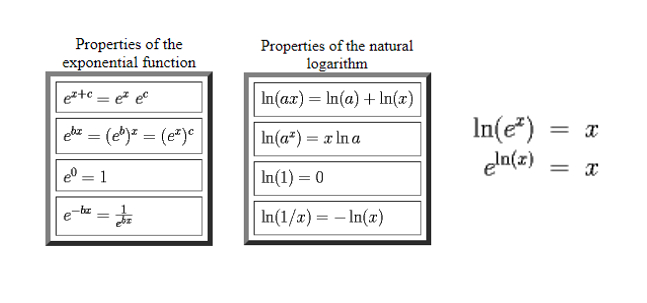

$1.0832 Log[DVD Sales Revenue] = Log[DVD Sales Revenue]^{1.0832} $

Take the exponent of both sides:<p>
$e^{1.0832 Log[DVD Sales Revenue]} = e^{Log[DVD Sales Revenue]^{1.0832}}$
</p>

$= DVD Sales Revenue^{1.0832}$

### Transforming the results back in Python

In [88]:
transformed_model_data['exp(y_hat)'] = np.exp(transformed_model_data['y_hat'])
transformed_model_data.head(5)

,Title,Blu Ray Units Sold,Blu Ray Sales Revenue,DVD Units Sold,DVD Sales Revenue,Log[Blu Ray Sales Revenue],Log[DVD Sales Revenue],y,y_hat,residuals,studentized_residuals,cooks_distance,exp(y_hat)
7,American Sniper,1735850,38907708,2556877,34785138,17.476703,17.364701,17.476703,17.177436,0.299267,0.523171,0.005164,2.884468e+07
46,Annie,302279,6367964,708107,10477294,15.666791,16.164721,15.666791,15.990397,-0.323607,-0.565237,0.005207,8.801187e+06
15,Ant-Man,1041107,22144021,856583,17123094,16.913078,16.655939,16.913078,16.476317,0.436761,0.764968,0.010090,1.430783e+07
2,Big Hero 6,2686595,52161672,2553831,41878065,17.769859,17.550273,17.769859,17.361007,0.408852,0.716330,0.009853,3.465688e+07
13,Cinderella,1112322,23541758,925118,14612596,16.974286,16.497395,16.974286,16.319483,0.654803,1.153832,0.022234,1.223098e+07


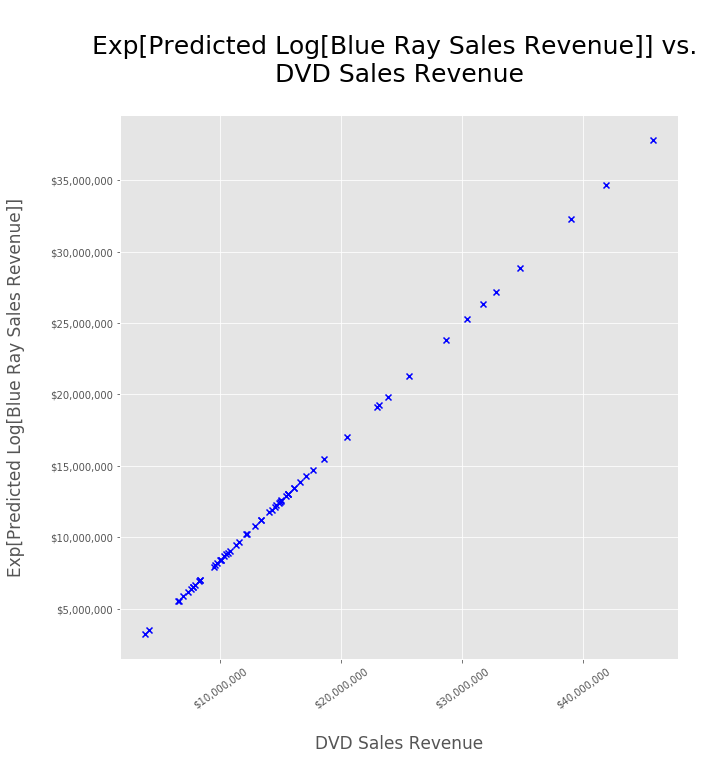

In [89]:
with plt.style.context('ggplot'):
    
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes()

    fmt = '${x:,.0f}'
    tick = ticker.StrMethodFormatter(fmt)

    ax.scatter(transformed_model_data['DVD Sales Revenue'],transformed_model_data['exp(y_hat)'], facecolors = 'blue', edgecolors='blue', marker = 'x', label = 'Predicted Blu Ray Sales Revenue from Log Tansformed Data')
    #ax.plot(transformed_model_data['DVD Sales Revenue'],transformed_model_data['exp(y_hat)'], color = 'dodgerblue', linewidth = 0.1)

    ax.yaxis.set_major_formatter(tick) 
    ax.xaxis.set_major_formatter(tick) 
    ax.tick_params(axis='x', rotation=35)

    ax.set_xlabel('\nDVD Sales Revenue', fontsize = 17)
    ax.set_ylabel('Exp[Predicted Log[Blue Ray Sales Revenue]]\n', fontsize = 17)
    ax.set_title('\nExp[Predicted Log[Blue Ray Sales Revenue]] vs. \nDVD Sales Revenue\n', fontsize = 25)
    plt.show()

# Compare the Models After Transforming the Results Back

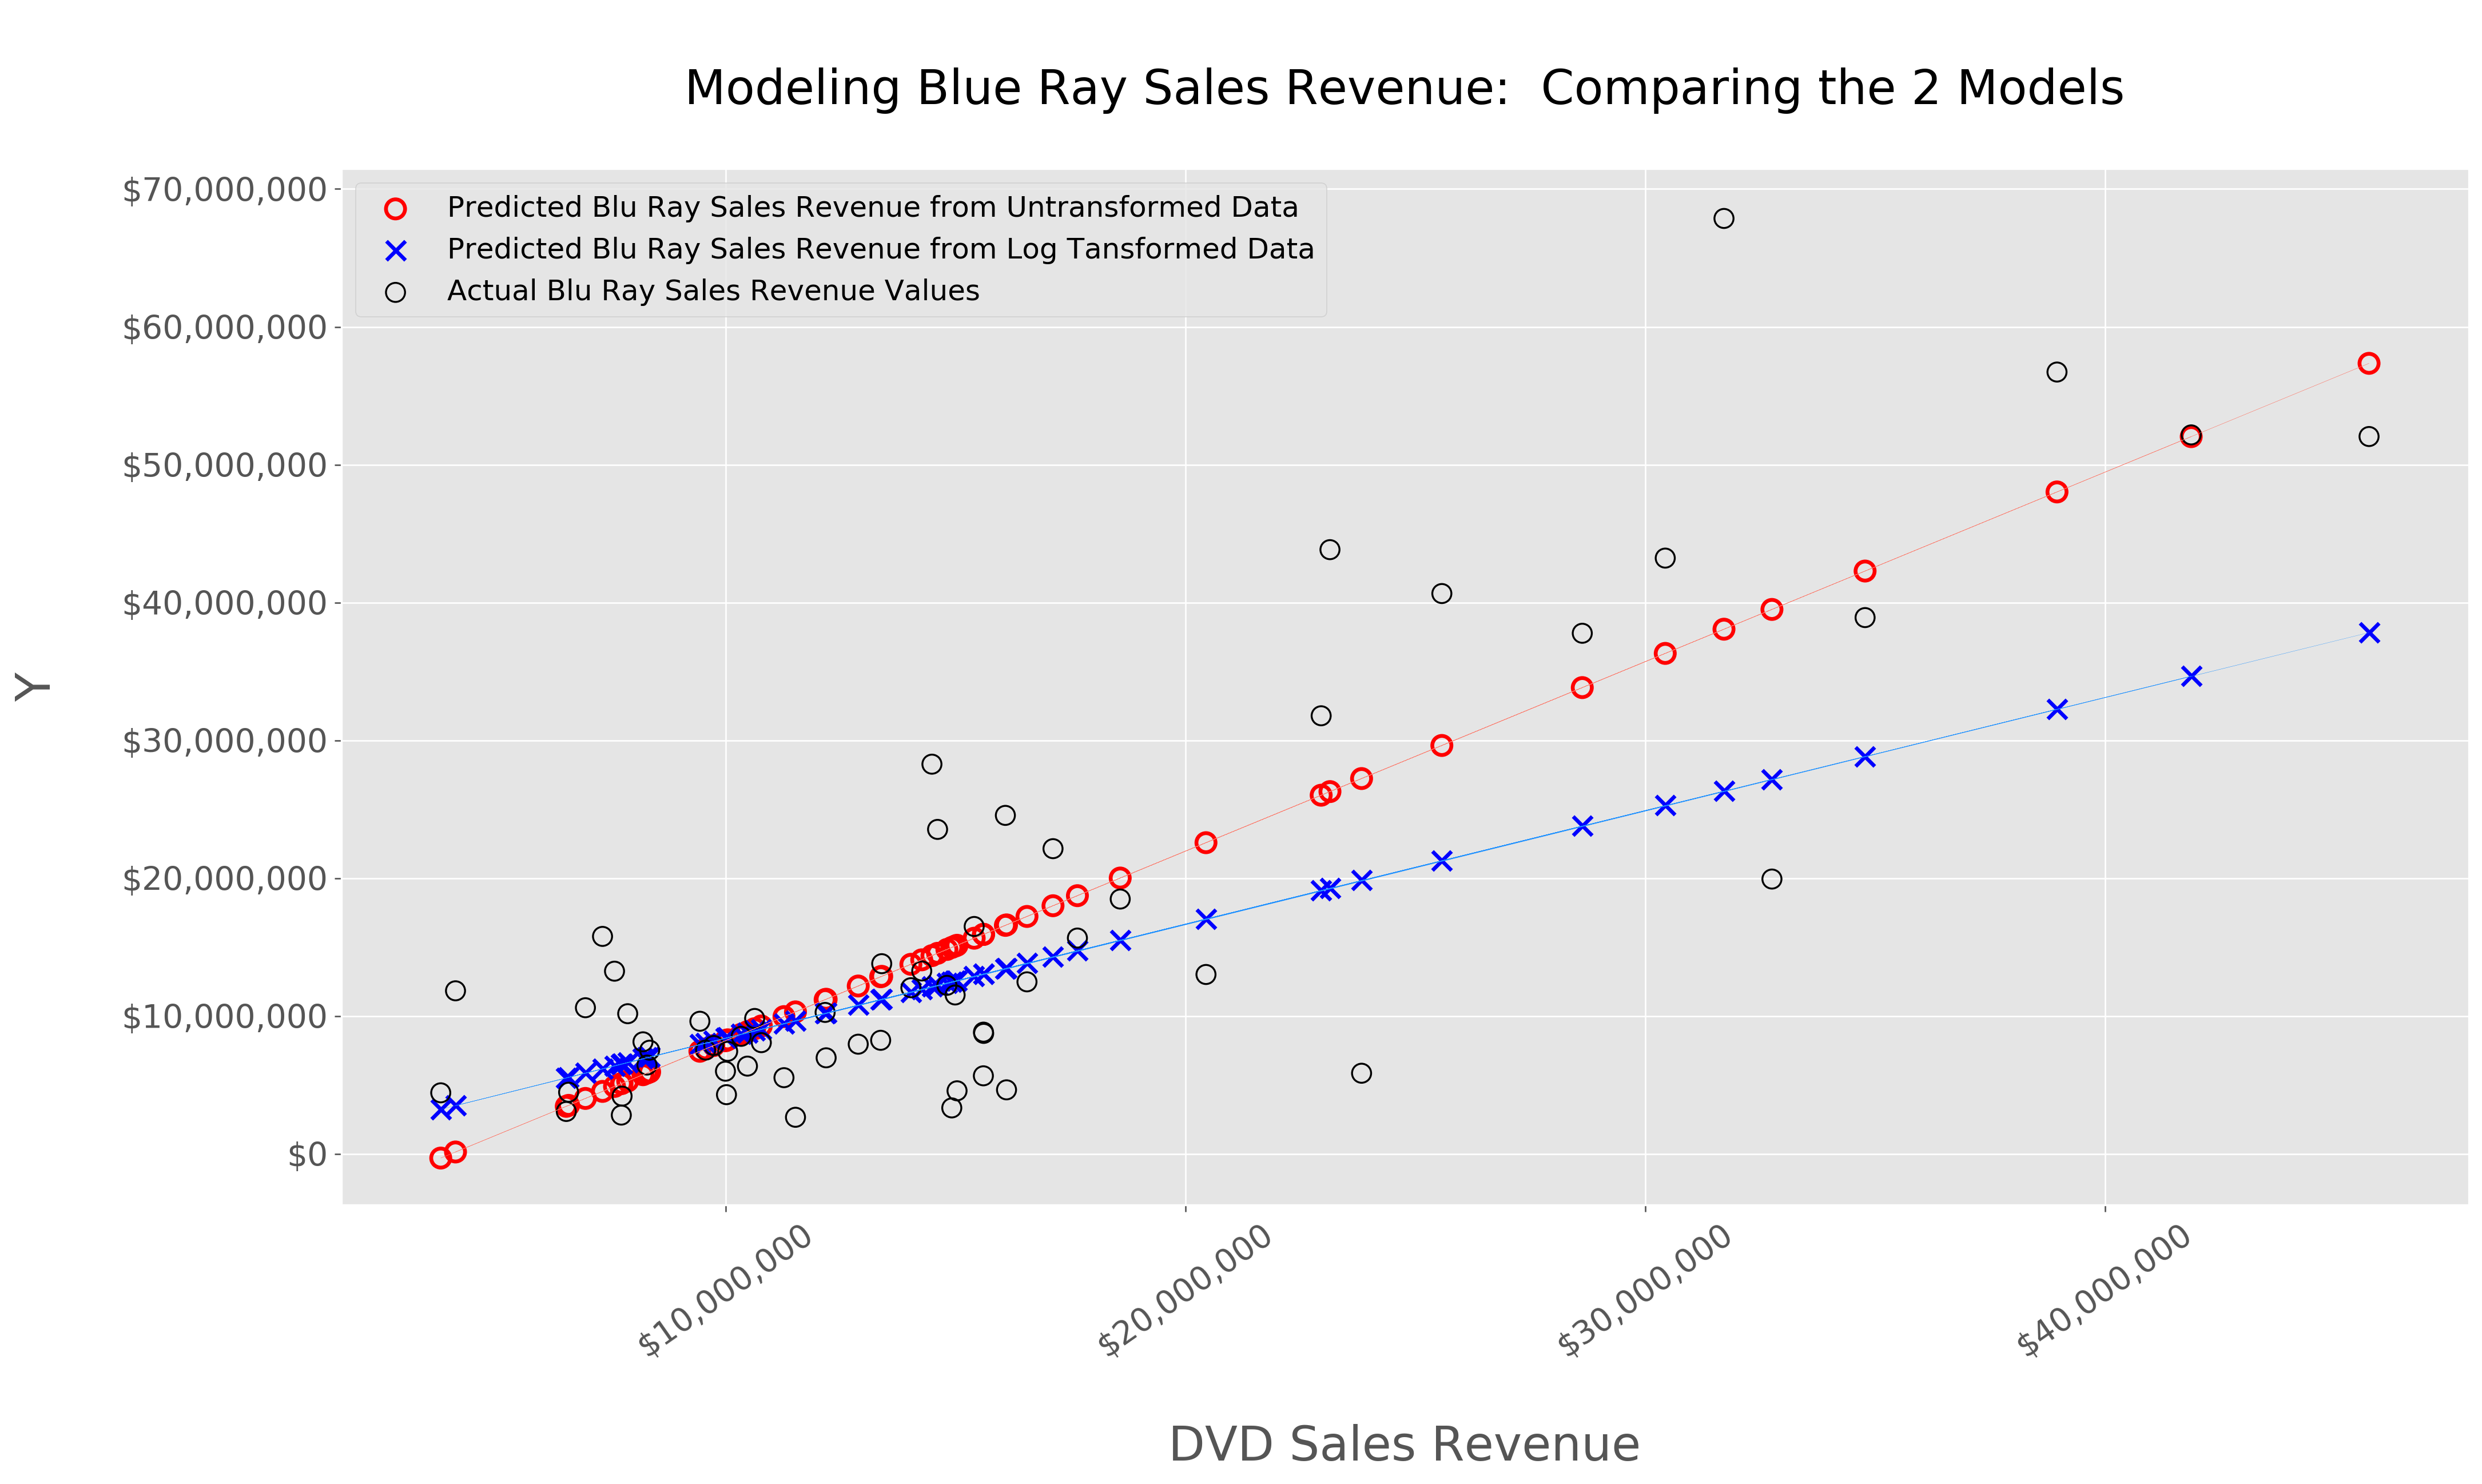

In [90]:
with plt.style.context('ggplot'):
    
    fig = plt.figure(figsize = (20,10), dpi=240)
    ax = plt.axes()

    fmt = '${x:,.0f}'
    tick = ticker.StrMethodFormatter(fmt)

    ax.scatter(non_transformed_model_data['DVD Sales Revenue'],non_transformed_model_data['y_hat'], facecolors='none', edgecolors='red', marker = 'o', linewidth = 2, s = 100, label = 'Predicted Blu Ray Sales Revenue from Untransformed Data')
    ax.scatter(transformed_model_data['DVD Sales Revenue'],transformed_model_data['exp(y_hat)'], facecolors = 'blue', edgecolors='blue', marker = 'x', linewidth = 2, s = 100, label = 'Predicted Blu Ray Sales Revenue from Log Tansformed Data')
    ax.scatter(transformed_model_data['DVD Sales Revenue'],transformed_model_data['Blu Ray Sales Revenue'], facecolors='none', edgecolors='black', linewidth = 1,s = 100, label = 'Actual Blu Ray Sales Revenue Values')

    ax.plot(non_transformed_model_data['DVD Sales Revenue'],non_transformed_model_data['y_hat'], color = 'salmon', linewidth = 0.1)
    ax.plot(transformed_model_data['DVD Sales Revenue'],transformed_model_data['exp(y_hat)'], color = 'dodgerblue', linewidth = 0.1)

    ax.yaxis.set_major_formatter(tick) 
    ax.xaxis.set_major_formatter(tick) 
    ax.tick_params(axis='x', rotation=35)

    ax.set_xlabel('\nDVD Sales Revenue', fontsize = 25)
    ax.set_ylabel('Y\n', fontsize = 25)
    ax.set_title('\nModeling Blue Ray Sales Revenue:  Comparing the 2 Models\n', fontsize = 25)
    ax.tick_params(axis='x', labelsize=17)
    ax.tick_params(axis='y', labelsize=17)    
    ax.legend(fontsize = 15)
    plt.show()